In [1]:
### Match Outcome Predictor Using Machine Learning
# In this notebook, we will develop a match outcome predictor by applying various machine learning algorithms and feature engineering techniques. The goal is to build a model that accurately forecasts match results based on available data.

# To achieve this, we will:

# Experiment with different algorithms, including Random Forests, Logistic Regression, and others, to assess which model performs best.
# Utilize feature engineering to transform and enhance the data, improving model performance and interpretability.

In [2]:
# imports 
import pandas as pd 
import os
import numpy as np 


# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning algorithms
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation and metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score

# For handling warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# lets look at our current data 
team_data = [
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/big_chance_missed_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/big_chance_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/clean_sheet_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/corner_taken_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/expected_goals_conceded_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/expected_goals_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/fk_foul_lost_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/goals_conceded_team_match.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/possession_percentage_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/possession_won_att_3rd_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/team_ratings.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/touches_in_opp_box_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/total_red_card_team.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/won_tackle_team.csv"
]

player_data = [
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_big_chances_created.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_expected_assists_per_90.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_expected_goals_per_90.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_penalties_conceded.csv",
    "/kaggle/input/premier-league-2324-team-and-player-insights/Premleg_23_24/player_player_ratings.csv",
]

In [4]:
# lets put them into dataframes 

team_dataframes = []
player_dataframes = []
results_dataframes = []

for path in team_data: 
    dataframe = pd.read_csv(path, index_col=0, sep=",")
    dataframe.drop(columns=['Matches', 'Country'], axis=1, inplace=True)
    team_dataframes.append(dataframe)

for path in player_data:
    dataframe = pd.read_csv(path, index_col=0, sep=",")
    dataframe.drop(columns=['Matches', 'Country'], axis=1, inplace=True)
    player_dataframes.append(dataframe)


In [5]:
# lets merge the dataframes together on the Team column, this will ensure all stats align with their associated team 
# ensuring accurate data analysis and an accurate model 

def merge_team_dataframes(dataframes, merge_column='Team'):
    """
    Merge multiple DataFrames with consistent team alignment and unique column names
    
    Parameters:
    dataframes (list): List of pandas DataFrames to merge
    merge_column (str): Column name used for merging (default 'Team')
    
    Returns:
    pandas.DataFrame: Merged DataFrame with all team-level information
    """
    # Validate input
    if not all(merge_column in df.columns for df in dataframes):
        raise ValueError(f"All DataFrames must contain a '{merge_column}' column")
    
    # Generate unique suffixes
    def generate_suffixes(dataframes):
        suffixes = []
        for i, df in enumerate(dataframes):
            suffix = f'_{i+1}'
            # Rename columns to avoid conflicts
            df.columns = [f'{col}{suffix}' if col != merge_column else col for col in df.columns]
            suffixes.append(suffix)
        return suffixes
    
    # Generate unique suffixes for non-merge columns
    generate_suffixes(dataframes)
    
    # Start with the first DataFrame
    merged_df = dataframes[0]
    
    # Progressively merge subsequent DataFrames
    for next_df in dataframes[1:]:
        merged_df = pd.merge(
            merged_df, 
            next_df, 
            on=merge_column, 
            how='outer'  # Keeps all teams even if missing in some DataFrames
        )
    
    # Rename merge column back to original
    merged_df.rename(columns={merge_column: 'Team'}, inplace=True)
    
    return merged_df

stats_df = merge_team_dataframes(team_dataframes)

stats_df.head()

,Team,Big Chances Missed_1,Goals_1,Big Chances_2,Goals_2,Clean Sheets_3,Corners Taken_4,Expected Goals Conceded_5,Goals Conceded_5,Expected Goals_6,...,Total Goals Conceded_8,Possession (%)_9,Possession Won Final 3rd per Match_10,Total Possessions Won_10,FotMob Team Rating_11,Touches in Opposition Box_12,Red Cards_13,Yellow Cards_13,Successful Tackles per Match_14,Tackle Success (%)_14
0,AFC Bournemouth,49.0,54.0,83.0,54.0,9.0,235.0,58.8,67.0,56.7,...,67.0,44.1,5.4,901.0,6.81,1101.0,3.0,79.0,10.8,59.2
1,Arsenal,63.0,91.0,113.0,91.0,18.0,265.0,28.4,29.0,77.4,...,29.0,58.4,6.7,820.0,7.18,1587.0,2.0,62.0,9.2,57.0
2,Aston Villa,58.0,76.0,98.0,76.0,8.0,231.0,60.7,61.0,64.7,...,61.0,53.3,4.1,632.0,6.91,1078.0,2.0,94.0,8.2,56.9
3,Brentford,69.0,56.0,107.0,56.0,7.0,184.0,56.7,65.0,59.8,...,65.0,45.0,4.8,798.0,6.82,1031.0,2.0,89.0,10.5,58.9
4,Brighton & Hove Albion,61.0,55.0,91.0,55.0,6.0,206.0,56.4,62.0,58.0,...,62.0,60.2,4.7,797.0,6.80,1158.0,3.0,91.0,9.6,56.8


In [6]:
def merge_player_dataframes(dataframes, merge_column='Player', 
                     unique_columns=['Team', 'Minutes'], 
                     suffixes=None):
    """
    Merge multiple DataFrames with flexible column handling
    
    Parameters:
    dataframes (list): List of pandas DataFrames to merge
    merge_column (str): Column name used for merging (default 'Player')
    unique_columns (list): Columns to keep only once in the merged DataFrame
    suffixes (list, optional): Custom suffixes for non-unique columns
    
    Returns:
    pandas.DataFrame: Merged DataFrame with controlled column naming
    """
    # Validate input
    if not all(merge_column in df.columns for df in dataframes):
        raise ValueError(f"All DataFrames must contain a '{merge_column}' column")
    
    # Prepare DataFrames
    processed_dfs = []
    for i, df in enumerate(dataframes):
        # Create a copy to avoid modifying original DataFrames
        processed_df = df.copy()
        
        # Separate unique and non-unique columns
        unique_cols = [col for col in unique_columns if col in processed_df.columns]
        non_unique_cols = [col for col in processed_df.columns 
                            if col not in unique_cols and col != merge_column]
        
        # Add suffix to non-unique columns
        if not suffixes:
            suffixes = [f'_{i+1}' for i in range(len(dataframes))]
        
        # Rename non-unique columns
        for col in non_unique_cols:
            processed_df.rename(columns={col: f'{col}{suffixes[i]}'}, inplace=True)
        
        processed_dfs.append(processed_df)
    
    # Merge DataFrames
    merged_df = processed_dfs[0]
    for next_df in processed_dfs[1:]:
        merged_df = pd.merge(
            merged_df, 
            next_df, 
            on=[merge_column] + unique_columns,
            how='outer'  # Keeps all players even if missing in some DataFrames
        )
    
    return merged_df

In [7]:
player_df = merge_player_dataframes(player_dataframes)

In [8]:
player_df.head(10)

,Player,Team,Big Chances Created_1,Total Assists_1,Minutes,Expected Assists per 90_2,Actual Assists per 90_2,Expected Goals per 90_3,Goals per 90_3,Penalties Conceded_4,Total Matches_4,FotMob Rating_5,Player of the Match Awards_5
0,Aaron Cresswell,West Ham United,1.0,0.0,432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aaron Ramsey,Burnley,1.0,0.0,524,NaN,NaN,NaN,NaN,1.0,14.0,NaN,NaN
2,Aaron Wan-Bissaka,Manchester United,1.0,2.0,1781,0.07,0.1,0.01,0.00,1.0,22.0,7.03,1.0
3,Abdoulaye Doucouré,Everton,4.0,2.0,2637,0.05,0.1,0.30,0.24,1.0,32.0,7.01,0.0
4,Adam Lallana,Brighton and Hove Albion,2.0,1.0,846,0.21,0.1,0.09,0.00,NaN,NaN,6.29,0.0
5,Adam Smith,Bournemouth,2.0,2.0,2156,0.07,0.1,0.00,0.00,2.0,28.0,6.71,0.0
6,Adam Wharton,Crystal Palace,5.0,3.0,1305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adama Traoré,Fulham,2.0,3.0,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Albert Sambi Lokonga,Luton Town,2.0,3.0,1308,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Alejandro Garnacho,Manchester United,6.0,4.0,2573,0.10,0.1,0.30,0.24,NaN,NaN,7.09,2.0


In [9]:
player_df = player_df.fillna(0)

In [10]:
player_df.columns


Index(['Player', 'Team', 'Big Chances Created_1', 'Total Assists_1', 'Minutes',
       'Expected Assists per 90_2', 'Actual Assists per 90_2',
       'Expected Goals per 90_3', 'Goals per 90_3', 'Penalties Conceded_4',
       'Total Matches_4', 'FotMob Rating_5', 'Player of the Match Awards_5'],
      dtype='object')

In [11]:
# feature engineering 

# we are going to look at the player statistics and engineer some features to add to the stats_df 
# for example we want to add a feature to a team like man city that will be a binary encoding
# i.e "top 5 player in xA" 

def get_top_players(df, statistic, top_n=3, min_minutes=None):
    """
    Extract top N players for a given statistic
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing player statistics
    statistic (str): Column name of the statistic to rank
    top_n (int): Number of top players to extract
    min_minutes (int, optional): minimum number of minutes to be considered
    
    Returns:
    pandas.DataFrame: DataFrame of top players
    """
    # Ensure the statistic column exists
    if statistic not in df.columns:
        raise ValueError(f"Statistic '{statistic}' not found in DataFrame")

    if min_minutes is not None:
          df_filtered = df[df['Minutes'] >= min_minutes]
    else:
        df_filtered = df
    
    # Sort in descending order and get top N
    top_players = df_filtered.sort_values(by=statistic, ascending=False).head(top_n)
    
    # Print out the top players for reference
    print(f"Top {top_n} players by {statistic}:")
    for index, row in top_players.iterrows():
        print(f"{row['Player']} ({row['Team']}): {row[statistic]}")
    
    return top_players

In [12]:
player_df.columns

Index(['Player', 'Team', 'Big Chances Created_1', 'Total Assists_1', 'Minutes',
       'Expected Assists per 90_2', 'Actual Assists per 90_2',
       'Expected Goals per 90_3', 'Goals per 90_3', 'Penalties Conceded_4',
       'Total Matches_4', 'FotMob Rating_5', 'Player of the Match Awards_5'],
      dtype='object')

In [13]:
min_min = 1500 # must play about 70% of games to be considered

top_xA = get_top_players(player_df, 'Expected Assists per 90_2', min_minutes=min_min)
top_A = get_top_players(player_df, 'Total Assists_1')
top_Ap90 = get_top_players(player_df, 'Actual Assists per 90_2', min_minutes=min_min)
top_xG = get_top_players(player_df, 'Expected Goals per 90_3', min_minutes=min_min)
top_Gp90 = get_top_players(player_df, 'Goals per 90_3', min_minutes=min_min)

Top 3 players by Expected Assists per 90_2:
Bukayo Saka (Arsenal): 0.34
Jérémy Doku (Manchester City): 0.33
Leon Bailey (Aston Villa): 0.32
Top 3 players by Total Assists_1:
Ollie Watkins (Aston Villa): 13.0
Cole Palmer (Chelsea): 11.0
Pascal Gross (Brighton and Hove Albion): 10.0
Top 3 players by Actual Assists per 90_2:
Pedro Neto (Wolverhampton Wanderers): 0.5
Jérémy Doku (Manchester City): 0.5
Leon Bailey (Aston Villa): 0.4
Top 3 players by Expected Goals per 90_3:
Erling Haaland (Manchester City): 1.03
Alexander Isak (Newcastle United): 0.81
Mohamed Salah (Liverpool): 0.75
Top 3 players by Goals per 90_3:
Erling Haaland (Manchester City): 0.95
Alexander Isak (Newcastle United): 0.83
Cole Palmer (Chelsea): 0.75


In [19]:
def add_top_player_column(main_df, top_players_dfs, statistics):
    """
    Add binary column indicating presence of top 5 players
    
    Parameters:
    main_df (pandas.DataFrame): Main DataFrame to add column to
    top_players_df (pandas.DataFrame): List of DataFrames of top players
    statistic (list): List of Statistics used for top player selection
    
    Returns:
    pandas.DataFrame: Main DataFrame with new binary columns
    """
    # Create sets of top players
    top_player_sets = []
    for top_player_df in top_players_dfs:
        top_player_sets.append(set(top_player_df['Team']))

    # Add binary columns
    for statistic in statistics:
        for tp_set in top_player_sets:
            main_df[f'has_top3_{statistic}'] = main_df['Team'].apply(
                lambda x: 1 if x in tp_set else 0
            )
    
    return main_df

In [11]:
# before adding player stats and engineering other stats lets find our baseline 

def calculate_winner(df): 
    """
    Add column indicating whether the home team won, away team won, are there was a draw

    Draw: 0
    Home: 1 
    Away: 2 
    
    
    Parameters:
    df (pandas.DataFrame): Main DataFrame to add column to
    
    Returns:
    pandas.DataFrame: Main DataFrame with new column
    """
    df[['home_score', 'away_score']] = df.Score.str.split('_', expand = True)

    df['winner'] = np.where(df.home_score > df.away_score, 1, np.where(df.away_score > df.home_score, 2, 0))

    return df 

In [12]:
match_data_2324 = pd.read_csv('/kaggle/input/premier-league-2324-team-and-player-insights/matches_23_24.csv')

match_data_2324.columns

match_data_2324.head()

,Round,Round Name,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,Unnamed: 11,Unnamed: 12
0,1,1,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,NaN,NaN
1,1,1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,NaN,NaN
2,1,1,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,NaN,NaN
3,1,1,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,NaN,NaN
4,1,1,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,NaN,NaN


In [13]:
match_data_9322 = pd.read_csv('/kaggle/input/english-premier-league-results/results.csv', encoding='ISO-8859-1')
match_data_9322.columns
match_data_9322.head()

,Season,DateTime,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HC,AC,HF,AF,HY,AY,HR,AR
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0,3,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4,1,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1,2,A,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2,0,H,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1,1,D,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
match_data_9322 = match_data_9322.dropna(axis=1, how='any')
match_data_9322.columns

Index(['Season', 'DateTime', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR'], dtype='object')

In [15]:
def format_dataframe(df):
    # Create a new 'score' column combining FTHG and FTAG
    df['score'] = df['FTHG'].astype(str) + '-' + df['FTAG'].astype(str)
    
    # Map FTR to the desired winner encoding
    winner_map = {
        'D': 0,  # Draw
        'H': 1,  # Home team wins
        'A': 2   # Away team wins
    }
    df['winner'] = df['FTR'].map(winner_map)
    
    # Drop the original FTHG, FTAG, and FTR columns
    df = df.drop(columns=['FTHG', 'FTAG', 'FTR'])

    df.rename(columns={'DateTime': 'UTC Time'}, inplace=True)
    
    return df

match_data_9322 = format_dataframe(match_data_9322)

match_data_9322.head()

,Season,UTC Time,HomeTeam,AwayTeam,score,winner
0,1993-94,1993-08-14T00:00:00Z,Arsenal,Coventry,0-3,2
1,1993-94,1993-08-14T00:00:00Z,Aston Villa,QPR,4-1,1
2,1993-94,1993-08-14T00:00:00Z,Chelsea,Blackburn,1-2,2
3,1993-94,1993-08-14T00:00:00Z,Liverpool,Sheffield Weds,2-0,1
4,1993-94,1993-08-14T00:00:00Z,Man City,Leeds,1-1,0


In [16]:
match_data_9322.rename(columns={'HomeTeam': 'Home Team', 'AwayTeam':'Away Team', 'score':'Score'}, inplace=True)

In [17]:
match_data_df = calculate_winner(match_data_2324)

In [18]:
match_data_df.drop(['Round','Round Name','Unnamed: 11', 'Unnamed: 12'], axis=1,inplace=True)

In [19]:
match_data_df['winner'].value_counts()

winner
1    243
0     72
2     66
Name: count, dtype: int64

In [20]:
match_data_9322['winner'].value_counts()

winner
1    5088
2    3161
0    2864
Name: count, dtype: int64

In [21]:
# 1: Home Team won 
# 0: Draw
# 2: Away Team won 
# total number of games = 11,494
# 5,331/11,494 ~ 46% 
# 2,936/11,494 ~ 25% 
# 3,227/11,494 ~ 28% 
# our baseline accuracy is 46% i.e choosing the majority class (home team) to win the game

In [22]:
# the next problem we must tackle is adding advanced statistics to the historical data
# this is the crux of this model as this is a difficult problem to solve, our 'current' data has advanced
# statistics readily available but in order to produce an 'accurate' model we need to fill in the gaps
# what technique to use? lets experiment with synthetic feature generation 

# using our small sample size of advanced metrics and the results the teams generated, we will create a model
# that will predict the advanced metrics

# so we can input the historical match data into this model and the output will be data that has the advanced metrics
# that we will then use to train our match predictor 

In [23]:
# START SYNTHETIC FEATURE GENERATION MODEL CLASS
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

class SyntheticFeatureGenerator: 
    
    def __init__(self, current_data, historical_data): 
        """
        Initialize the synthetic feature generator
        
        Parameters:
        -----------
        current_data : pd.DataFrame
            DataFrame with full set of features including advanced metrics
        historical_data : pd.DataFrame
            DataFrame with limited features, missing advanced metrics
        """
        self.current_data = current_data
        self.historical_data = historical_data
        
        # Identify base and advanced features
        self.advanced_metrics = self._identify_advanced_metrics()
        self.base_features = self._identify_base_features()

        print("Current Dataset Columns:")
        print(self.current_data.columns.tolist())

        print("\nHistorical Dataset Columns:")
        print(self.historical_data.columns.tolist())

        print("\nBase Features Identified:")
        print(self.base_features)


    def _identify_base_features(self): 
        """
        Identify base features that exist in both current and historical datasets
        """
        # Get columns from both datasets
        current_columns = set(self.current_data.columns)
        historical_columns = set(self.historical_data.columns)
    
        # Find common columns, excluding advanced metrics and boolean features
        base_features = [
            col for col in current_columns.intersection(historical_columns)
            if not any(metric in col for metric in [
                'Big Chances Missed', 'Goals', 'Big Chances', 'Clean Sheets', 
                'Corners Taken', 'Expected Goals', 'Goals Conceded', 
                'Fouls per Match', 'Yellow Cards', 'Possession', 
                'FotMob Team Rating', 'Touches in Opposition Box', 
                'Red Cards', 'Successful Tackles', 'Tackle Success'
            ])
            and not col.startswith('has_')
        ]
        return base_features

    def _identify_advanced_metrics(self): 
        """
        Identify advanced metrics to be predicted
        """
        return [
            col for col in self.current_data.columns 
            if any(metric in col for metric in [
                'Big Chances Missed', 'Goals', 'Big Chances', 'Clean Sheets', 
                'Corners Taken', 'Expected Goals', 'Goals Conceded', 
                'Fouls per Match', 'Yellow Cards', 'Possession', 
                'FotMob Team Rating', 'Touches in Opposition Box', 
                'Red Cards', 'Successful Tackles', 'Tackle Success', 'goals_difference', 
                'expected_goals_difference', 'goals_conceded_difference', 'home_xg_to_goals_ratio',
                'away_xg_to_goals_ratio', 'home_offensive_rating', 'away_offensive_rating'
                
            ])
        ]

    def prepare_data(self): 
        """
        Prepare data for model training
        
        Returns:
        --------
        X_train : np.array
            Training features
        y_train : np.array
            Training target advanced metrics
        X_test : np.array
            Historical data features for prediction
        """
        # Select base features and advanced metrics from current data
        X = self.current_data[self.base_features]
        y = self.current_data[self.advanced_metrics]

        imputer = SimpleImputer(strategy='mean')

        y_imputed = pd.DataFrame(
        imputer.fit_transform(y), 
        columns=y.columns, 
        index=y.index
        )
        
        # Select base features from historical data
        X_historical = self.historical_data[self.base_features]
        
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_historical_scaled = scaler.transform(X_historical)
        
        return X_scaled, y_imputed, X_historical_scaled

    def train_synthetic_model(self): 
        """
        Train a multi-output regression model to predict advanced metrics
        
        Returns:
        --------
        model : MultiOutputRegressor
            Trained model for synthetic feature generation
        """
        # Prepare data
        X_train, y_train, X_historical = self.prepare_data()
        
        # Initialize and train multi-output random forest regressor
        base_model = RandomForestRegressor(
            n_estimators=100, 
            random_state=42, 
            n_jobs=-1
        )
        multi_output_model = MultiOutputRegressor(base_model)
        multi_output_model.fit(X_train, y_train)
        
        # Perform cross-validation
        cv_scores = cross_val_score(
            multi_output_model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
        print("Cross-validation MSE scores:", -cv_scores)
        print("Mean CV Score:", -cv_scores.mean())

        return multi_output_model

    def generate_synthetic_features(self, model):
        """
        Generate synthetic advanced metrics for historical data
        
        Parameters:
        -----------
        model : MultiOutputRegressor
            Trained synthetic feature generation model
        
        Returns:
        --------
        historical_data_with_synthetic : pd.DataFrame
            Historical data with added synthetic advanced metrics
        """
        # Prepare historical data features
        _, _, X_historical = self.prepare_data()
        
        # Predict advanced metrics
        synthetic_metrics = model.predict(X_historical)
        
        # Create DataFrame with synthetic metrics
        synthetic_df = pd.DataFrame(
            synthetic_metrics, 
            columns=self.advanced_metrics, 
            index=self.historical_data.index
        )
        
        # Combine historical data with synthetic metrics
        historical_data_with_synthetic = pd.concat([
            self.historical_data, 
            synthetic_df
        ], axis=1)
        
        return historical_data_with_synthetic


# END SYNTHETIC FEATURE GENERATION MODEL CLASS

In [24]:
stats_df = add_top_player_column(stats_df, [top_xA, top_A, top_Ap90, top_xG, top_Gp90], ['xA', 'Assists', 'Assists p90', 'xG', 'Goals p90'])

NameError: name 'add_top_player_column' is not defined

In [25]:
stats_df.head()

,Team,Big Chances Missed_1,Goals_1,Big Chances_2,Goals_2,Clean Sheets_3,Corners Taken_4,Expected Goals Conceded_5,Goals Conceded_5,Expected Goals_6,...,Total Goals Conceded_8,Possession (%)_9,Possession Won Final 3rd per Match_10,Total Possessions Won_10,FotMob Team Rating_11,Touches in Opposition Box_12,Red Cards_13,Yellow Cards_13,Successful Tackles per Match_14,Tackle Success (%)_14
0,AFC Bournemouth,49.0,54.0,83.0,54.0,9.0,235.0,58.8,67.0,56.7,...,67.0,44.1,5.4,901.0,6.81,1101.0,3.0,79.0,10.8,59.2
1,Arsenal,63.0,91.0,113.0,91.0,18.0,265.0,28.4,29.0,77.4,...,29.0,58.4,6.7,820.0,7.18,1587.0,2.0,62.0,9.2,57.0
2,Aston Villa,58.0,76.0,98.0,76.0,8.0,231.0,60.7,61.0,64.7,...,61.0,53.3,4.1,632.0,6.91,1078.0,2.0,94.0,8.2,56.9
3,Brentford,69.0,56.0,107.0,56.0,7.0,184.0,56.7,65.0,59.8,...,65.0,45.0,4.8,798.0,6.82,1031.0,2.0,89.0,10.5,58.9
4,Brighton & Hove Albion,61.0,55.0,91.0,55.0,6.0,206.0,56.4,62.0,58.0,...,62.0,60.2,4.7,797.0,6.80,1158.0,3.0,91.0,9.6,56.8


In [26]:
match_data_df.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,away_score,winner
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,3,1
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,1,1
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,1,0
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,1,1
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,1,1


In [27]:
# combine team statistics with the match data 

print(stats_df.columns)
print(match_data_df.columns)
print(match_data_df.shape)



Index(['Team', 'Big Chances Missed_1', 'Goals_1', 'Big Chances_2', 'Goals_2',
       'Clean Sheets_3', 'Corners Taken_4', 'Expected Goals Conceded_5',
       'Goals Conceded_5', 'Expected Goals_6', 'Goals_6', 'Fouls per Match_7',
       'Yellow Cards_7', 'Goals Conceded per Match_8',
       'Total Goals Conceded_8', 'Possession (%)_9',
       'Possession Won Final 3rd per Match_10', 'Total Possessions Won_10',
       'FotMob Team Rating_11', 'Touches in Opposition Box_12', 'Red Cards_13',
       'Yellow Cards_13', 'Successful Tackles per Match_14',
       'Tackle Success (%)_14'],
      dtype='object')
Index(['Home Team', 'Away Team', 'UTC Time', 'Finished', 'Started',
       'Cancelled', 'Awarded', 'Score', 'Match Status', 'home_score',
       'away_score', 'winner'],
      dtype='object')
(381, 12)


In [28]:
stats_df.drop(['Goals_2'], axis=1,inplace=True)

In [29]:
def merge_team_stats_with_matches(matches_df, team_stats_df):
    """
    Merge team stats for both home and away teams into the matches dataframe
    
    Parameters:
    - matches_df: DataFrame with 'home_team' and 'away_team' columns
    - team_stats_df: DataFrame with team statistics
    
    Returns:
    - Merged DataFrame with home and away team stats
    """
    # Create copies to avoid SettingWithCopyWarning
    matches = matches_df.copy()
    team_stats = team_stats_df.copy()
    
    # Merge home team stats
    matches = matches.merge(
        team_stats, 
        left_on='Home Team', 
        right_on='Team', 
        how='left', 
        suffixes=('', '_home')
    )
    
    # Merge away team stats
    matches = matches.merge(
        team_stats, 
        left_on='Away Team', 
        right_on='Team', 
        how='left', 
        suffixes=('_home', '_away')
    )
    
    # Optional: Drop redundant columns if needed
    columns_to_drop = [col for col in matches.columns if col.endswith('_home_away') or col.endswith('_away_team')]
    matches.drop(columns=columns_to_drop, inplace=True)
    
    return matches

In [30]:
dataset = merge_team_stats_with_matches(match_data_df, stats_df)

In [31]:
# Current Data Dataset
dataset.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,...,Total Goals Conceded_8_away,Possession (%)_9_away,Possession Won Final 3rd per Match_10_away,Total Possessions Won_10_away,FotMob Team Rating_11_away,Touches in Opposition Box_12_away,Red Cards_13_away,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,...,34.0,65.4,7.5,787.0,7.37,1573.0,2.0,52.0,8.0,59.0
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,...,67.0,40.3,3.4,682.0,6.78,824.0,3.0,78.0,11.3,58.9
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,...,74.0,40.7,4.3,751.0,6.89,800.0,3.0,76.0,11.2,62.3
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,...,85.0,42.2,4.2,765.0,6.69,830.0,NaN,NaN,9.7,56.3
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,...,61.0,50.7,4.0,775.0,6.82,891.0,4.0,78.0,10.1,56.6


In [32]:
dataset.columns

Index(['Home Team', 'Away Team', 'UTC Time', 'Finished', 'Started',
       'Cancelled', 'Awarded', 'Score', 'Match Status', 'home_score',
       'away_score', 'winner', 'Team_home', 'Big Chances Missed_1_home',
       'Goals_1_home', 'Big Chances_2_home', 'Clean Sheets_3_home',
       'Corners Taken_4_home', 'Expected Goals Conceded_5_home',
       'Goals Conceded_5_home', 'Expected Goals_6_home', 'Goals_6_home',
       'Fouls per Match_7_home', 'Yellow Cards_7_home',
       'Goals Conceded per Match_8_home', 'Total Goals Conceded_8_home',
       'Possession (%)_9_home', 'Possession Won Final 3rd per Match_10_home',
       'Total Possessions Won_10_home', 'FotMob Team Rating_11_home',
       'Touches in Opposition Box_12_home', 'Red Cards_13_home',
       'Yellow Cards_13_home', 'Successful Tackles per Match_14_home',
       'Tackle Success (%)_14_home', 'Team_away', 'Big Chances Missed_1_away',
       'Goals_1_away', 'Big Chances_2_away', 'Clean Sheets_3_away',
       'Corners Taken_4

In [33]:
def advanced_feature_engineering(df):
    # Create home-away difference features
    home_cols = [col for col in df.columns if col.endswith('_home')]
    away_cols = [col for col in df.columns if col.endswith('_away')]
    
    feature_engineering_map = {
        # Performance Difference Features
        'goals_difference': ('Goals_1_home', 'Goals_1_away'),
        'expected_goals_difference': ('Expected Goals_6_home', 'Expected Goals_6_away'),
        'goals_conceded_difference': ('Goals Conceded_5_home', 'Goals Conceded_5_away'),
        
        # Ratio Features
        'home_xg_to_goals_ratio': ('Expected Goals_6_home', 'Goals_6_home'),
        'away_xg_to_goals_ratio': ('Expected Goals_6_away', 'Goals_6_away'),
        
        # Performance Indicators
        'home_offensive_rating': (
            'Goals_1_home', 
            'Touches in Opposition Box_12_home', 
            'Big Chances_2_home'
        ),
        'away_offensive_rating': (
            'Goals_1_away', 
            'Touches in Opposition Box_12_away', 
            'Big Chances_2_away'
        )
    }
    
    for new_feature, source_cols in feature_engineering_map.items():
        if len(source_cols) == 2:
            # Difference or simple ratio features
            df[new_feature] = df[source_cols[0]] - df[source_cols[1]]
        else:
            # Complex rating features
            df[new_feature] = (
                df[source_cols[0]] / df[source_cols[0]].mean() +
                df[source_cols[1]] / df[source_cols[1]].mean() +
                df[source_cols[2]] / df[source_cols[2]].mean()
            ) / 3
    
    return df


In [34]:
dataset_advanced_metrics = advanced_feature_engineering(dataset)

In [35]:
dataset_advanced_metrics.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,...,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away,goals_difference,expected_goals_difference,goals_conceded_difference,home_xg_to_goals_ratio,away_xg_to_goals_ratio,home_offensive_rating,away_offensive_rating
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,...,52.0,8.0,59.0,-55.0,-41.0,44.0,-0.1,-14.1,0.710501,1.458041
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,...,78.0,11.3,58.9,42.0,27.0,-38.0,-13.6,1.4,1.395136,0.815152
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,...,76.0,11.2,62.3,-6.0,3.8,-7.0,2.7,-7.1,0.935729,0.862866
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,...,NaN,9.7,56.3,3.0,14.6,-23.0,3.0,-8.6,0.988004,0.774984
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,...,78.0,10.1,56.6,-15.0,3.3,-10.0,14.9,-3.4,0.805893,0.824720


In [36]:
from sklearn.preprocessing import LabelEncoder

def encode_teams_and_UTC(current_data, historical_data):
        """
        Encode team names using LabelEncoder
    
        Parameters:
        -----------
        current_data : pd.DataFrame
            Current dataset
        historical_data : pd.DataFrame
            Historical dataset
    
        Returns:
        --------
        current_data : pd.DataFrame
            Current data with encoded teams
        historical_data : pd.DataFrame
            Historical data with encoded teams
        """
        # Create label encoder
        home_team_encoder = LabelEncoder()
        away_team_encoder = LabelEncoder()
        utc_encoder = LabelEncoder()
    
        # Fit encoders on combined unique team names
        all_home_teams = set(current_data['Home Team'].unique()).union(historical_data['Home Team'].unique())
        all_away_teams = set(current_data['Away Team'].unique()).union(historical_data['Away Team'].unique())
        all_UTC = set(current_data['UTC Time'].unique()).union(historical_data['UTC Time'].unique())
        home_team_encoder.fit(list(all_home_teams))
        away_team_encoder.fit(list(all_away_teams))
        utc_encoder.fit(list(all_UTC))
    
        # Encode teams in both datasets
        current_data['HomeTeam_encoded'] = home_team_encoder.transform(current_data['Home Team'])
        current_data['AwayTeam_encoded'] = away_team_encoder.transform(current_data['Away Team'])

        current_data['UTC_encoded'] = utc_encoder.transform(current_data['UTC Time'])
        historical_data['UTC_encoded'] = utc_encoder.transform(historical_data['UTC Time'])
    
        historical_data['HomeTeam_encoded'] = home_team_encoder.transform(historical_data['Home Team'])
        historical_data['AwayTeam_encoded'] = away_team_encoder.transform(historical_data['Away Team'])
        
        return current_data, historical_data

In [37]:
current_data, historical_data = encode_teams_and_UTC(dataset_advanced_metrics, match_data_9322)

In [38]:
current_data = current_data.drop(['Home Team', 'Away Team', 'Score', 'UTC Time'], axis=1)
historical_data = historical_data.drop(['Home Team', 'Away Team', 'Score', 'UTC Time'], axis=1)

In [39]:
# now we have a complete 'current' dataset

# Create the generator

generator = SyntheticFeatureGenerator(current_data, historical_data)

Current Dataset Columns:
['Finished', 'Started', 'Cancelled', 'Awarded', 'Match Status', 'home_score', 'away_score', 'winner', 'Team_home', 'Big Chances Missed_1_home', 'Goals_1_home', 'Big Chances_2_home', 'Clean Sheets_3_home', 'Corners Taken_4_home', 'Expected Goals Conceded_5_home', 'Goals Conceded_5_home', 'Expected Goals_6_home', 'Goals_6_home', 'Fouls per Match_7_home', 'Yellow Cards_7_home', 'Goals Conceded per Match_8_home', 'Total Goals Conceded_8_home', 'Possession (%)_9_home', 'Possession Won Final 3rd per Match_10_home', 'Total Possessions Won_10_home', 'FotMob Team Rating_11_home', 'Touches in Opposition Box_12_home', 'Red Cards_13_home', 'Yellow Cards_13_home', 'Successful Tackles per Match_14_home', 'Tackle Success (%)_14_home', 'Team_away', 'Big Chances Missed_1_away', 'Goals_1_away', 'Big Chances_2_away', 'Clean Sheets_3_away', 'Corners Taken_4_away', 'Expected Goals Conceded_5_away', 'Goals Conceded_5_away', 'Expected Goals_6_away', 'Goals_6_away', 'Fouls per Match_7

In [40]:
# Train synthetic feature generation model
synthetic_model = generator.train_synthetic_model()

Cross-validation MSE scores: [17.90477938 14.62659359 18.72132892 10.60586301 20.67957485]
Mean CV Score: 16.507627952333756


In [ ]:
historical_data_enhanced = generator.generate_synthetic_features(synthetic_model)

In [42]:
historical_data_enhanced.head()

,Season,winner,UTC_encoded,HomeTeam_encoded,AwayTeam_encoded,Big Chances Missed_1_home,Goals_1_home,Big Chances_2_home,Clean Sheets_3_home,Corners Taken_4_home,...,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away,goals_difference,expected_goals_difference,goals_conceded_difference,home_xg_to_goals_ratio,away_xg_to_goals_ratio,home_offensive_rating,away_offensive_rating
0,1993-94,2,0,1,17,59.43,90.85,98.79,17.84,265.00,...,105.0,9.90,56.700,0.95,-11.461,-3.84,-13.6,-1.7,1.360912,1.203061
1,1993-94,1,0,2,41,58.15,76.00,97.62,8.00,231.00,...,95.0,10.70,57.100,25.79,12.887,-43.67,-11.3,4.0,1.100715,0.630396
2,1993-94,2,0,16,5,55.58,76.64,91.14,8.67,201.79,...,94.0,8.20,56.900,-21.13,-19.289,11.14,-1.7,-11.3,1.174302,1.101159
3,1993-94,1,0,27,44,78.68,86.00,126.69,9.99,286.99,...,95.0,10.70,57.100,21.77,30.798,-46.44,3.4,4.0,1.400187,0.630396
4,1993-94,0,0,29,25,28.34,52.34,65.58,2.00,204.66,...,65.0,10.97,61.646,-15.22,-26.284,27.74,-8.6,3.4,0.774664,1.400205


In [43]:
# end synthetic data generation

In [44]:
# advanced metrics model computation starts here
dataset_advanced_metrics = dataset_advanced_metrics.fillna(0)

In [45]:
dataset_advanced_metrics.head()

,Home Team,Away Team,UTC Time,Finished,Started,Cancelled,Awarded,Score,Match Status,home_score,...,goals_difference,expected_goals_difference,goals_conceded_difference,home_xg_to_goals_ratio,away_xg_to_goals_ratio,home_offensive_rating,away_offensive_rating,HomeTeam_encoded,AwayTeam_encoded,UTC_encoded
0,Burnley,Manchester City,2023-08-11T19:00:00Z,True,True,False,False,0 _ 3,Full-Time,0,...,-55.0,-41.0,44.0,-0.1,-14.1,0.710501,1.458041,13,31,3443
1,Arsenal,Nottingham Forest,2023-08-12T12:00:00Z,True,True,False,False,2_1,Full-Time,2,...,42.0,27.0,-38.0,-13.6,1.4,1.395136,0.815152,1,38,3444
2,AFC Bournemouth,West Ham United,2023-08-12T14:00:00Z,True,True,False,False,1_1,Full-Time,1,...,-6.0,3.8,-7.0,2.7,-7.1,0.935729,0.862866,0,55,3445
3,Brighton & Hove Albion,Luton Town,2023-08-12T14:00:00Z,True,True,False,False,4_1,Full-Time,4,...,3.0,14.6,-23.0,3.0,-8.6,0.988004,0.774984,12,28,3445
4,Everton,Fulham,2023-08-12T14:00:00Z,True,True,False,False,0 _ 1,Full-Time,0,...,-15.0,3.3,-10.0,14.9,-3.4,0.805893,0.824720,20,21,3445


In [46]:
# now we merge the two datasets together and then we can train our match prediction model :)
# lets see what the different columns are 

hd = set(historical_data_enhanced.columns)
ad = set(dataset_advanced_metrics.columns)

out = []

for a in ad: 
    if a not in hd: 
        out.append(a)
print(out)

['home_score', 'Team_home', 'away_score', 'Match Status', 'Home Team', 'Score', 'Awarded', 'Away Team', 'Cancelled', 'UTC Time', 'Started', 'Team_away', 'Finished']


In [47]:
# for now lets drop the columns that are not in common 

dataset_advanced_metrics.drop(columns=out, inplace=True)

In [48]:
historical_data_enhanced.drop(columns=['Season'], inplace=True)

In [49]:
# lets combine the datasets

combined_dataset = pd.concat([historical_data_enhanced, dataset_advanced_metrics], axis=0)

combined_dataset.head()

,winner,UTC_encoded,HomeTeam_encoded,AwayTeam_encoded,Big Chances Missed_1_home,Goals_1_home,Big Chances_2_home,Clean Sheets_3_home,Corners Taken_4_home,Expected Goals Conceded_5_home,...,Yellow Cards_13_away,Successful Tackles per Match_14_away,Tackle Success (%)_14_away,goals_difference,expected_goals_difference,goals_conceded_difference,home_xg_to_goals_ratio,away_xg_to_goals_ratio,home_offensive_rating,away_offensive_rating
0,2,0,1,17,59.43,90.85,98.79,17.84,265.00,28.835,...,105.0,9.90,56.700,0.95,-11.461,-3.84,-13.6,-1.7,1.360912,1.203061
1,1,0,2,41,58.15,76.00,97.62,8.00,231.00,61.036,...,95.0,10.70,57.100,25.79,12.887,-43.67,-11.3,4.0,1.100715,0.630396
2,2,0,16,5,55.58,76.64,91.14,8.67,201.79,60.567,...,94.0,8.20,56.900,-21.13,-19.289,11.14,-1.7,-11.3,1.174302,1.101159
3,1,0,27,44,78.68,86.00,126.69,9.99,286.99,46.200,...,95.0,10.70,57.100,21.77,30.798,-46.44,3.4,4.0,1.400187,0.630396
4,0,0,29,25,28.34,52.34,65.58,2.00,204.66,79.800,...,65.0,10.97,61.646,-15.22,-26.284,27.74,-8.6,3.4,0.774664,1.400205


In [50]:
combined_dataset.columns

Index(['winner', 'UTC_encoded', 'HomeTeam_encoded', 'AwayTeam_encoded',
       'Big Chances Missed_1_home', 'Goals_1_home', 'Big Chances_2_home',
       'Clean Sheets_3_home', 'Corners Taken_4_home',
       'Expected Goals Conceded_5_home', 'Goals Conceded_5_home',
       'Expected Goals_6_home', 'Goals_6_home', 'Fouls per Match_7_home',
       'Yellow Cards_7_home', 'Goals Conceded per Match_8_home',
       'Total Goals Conceded_8_home', 'Possession (%)_9_home',
       'Possession Won Final 3rd per Match_10_home',
       'Total Possessions Won_10_home', 'FotMob Team Rating_11_home',
       'Touches in Opposition Box_12_home', 'Red Cards_13_home',
       'Yellow Cards_13_home', 'Successful Tackles per Match_14_home',
       'Tackle Success (%)_14_home', 'Big Chances Missed_1_away',
       'Goals_1_away', 'Big Chances_2_away', 'Clean Sheets_3_away',
       'Corners Taken_4_away', 'Expected Goals Conceded_5_away',
       'Goals Conceded_5_away', 'Expected Goals_6_away', 'Goals_6_away',
 

In [51]:
# drop redundant columns 

combined_dataset.drop(columns=['Goals_6_home', 'Goals_6_away'], inplace=True)

In [52]:
# check for data leak (duplicates)

duplicate_rows = combined_dataset[combined_dataset.duplicated()]

print(duplicate_rows)


Empty DataFrame
Columns: [winner, UTC_encoded, HomeTeam_encoded, AwayTeam_encoded, Big Chances Missed_1_home, Goals_1_home, Big Chances_2_home, Clean Sheets_3_home, Corners Taken_4_home, Expected Goals Conceded_5_home, Goals Conceded_5_home, Expected Goals_6_home, Fouls per Match_7_home, Yellow Cards_7_home, Goals Conceded per Match_8_home, Total Goals Conceded_8_home, Possession (%)_9_home, Possession Won Final 3rd per Match_10_home, Total Possessions Won_10_home, FotMob Team Rating_11_home, Touches in Opposition Box_12_home, Red Cards_13_home, Yellow Cards_13_home, Successful Tackles per Match_14_home, Tackle Success (%)_14_home, Big Chances Missed_1_away, Goals_1_away, Big Chances_2_away, Clean Sheets_3_away, Corners Taken_4_away, Expected Goals Conceded_5_away, Goals Conceded_5_away, Expected Goals_6_away, Fouls per Match_7_away, Yellow Cards_7_away, Goals Conceded per Match_8_away, Total Goals Conceded_8_away, Possession (%)_9_away, Possession Won Final 3rd per Match_10_away, Tota

In [ ]:
# no duplicates! 

In [53]:
# START MODEL TRAINING
X = combined_dataset.drop('winner', axis=1)
y = combined_dataset.winner.values

In [54]:
X.shape

(11494, 52)

In [55]:
y.shape

(11494,)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [57]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import time

models = [LogisticRegression(max_iter= 1000, multi_class = 'multinomial'),
RandomForestClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), XGBClassifier()]

names = ['Logistic Regression', 'Random Forest', 'Gradient Boost', 'KNN', 'XGBoost']

#loop through each model and print train score and elapsed time
for model, name in zip(models, names):
    start = time.time()
    scores = cross_val_score(model, X_train, y_train ,scoring= 'accuracy', cv=5)
    print(name, ":", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), " - Elapsed time: ", time.time() - start)

Logistic Regression : 0.729, +- 0.008  - Elapsed time:  7.776933431625366
Random Forest : 0.983, +- 0.003  - Elapsed time:  6.343280076980591
Gradient Boost : 0.965, +- 0.005  - Elapsed time:  52.11877179145813
KNN : 0.706, +- 0.010  - Elapsed time:  0.6555459499359131
XGBoost : 0.984, +- 0.003  - Elapsed time:  4.230830907821655


 knn result : 0.980, +- 0.002 N_features : 5
 knn result : 0.979, +- 0.003 N_features : 6
 knn result : 0.982, +- 0.002 N_features : 7
 knn result : 0.982, +- 0.000 N_features : 8
 knn result : 0.982, +- 0.005 N_features : 9
 knn result : 0.983, +- 0.004 N_features : 10
 knn result : 0.984, +- 0.002 N_features : 11
 knn result : 0.986, +- 0.002 N_features : 12
 knn result : 0.985, +- 0.002 N_features : 13
 knn result : 0.982, +- 0.005 N_features : 14
 knn result : 0.986, +- 0.003 N_features : 15
 knn result : 0.986, +- 0.003 N_features : 16
 knn result : 0.984, +- 0.002 N_features : 17
 knn result : 0.983, +- 0.002 N_features : 18
 knn result : 0.984, +- 0.002 N_features : 19


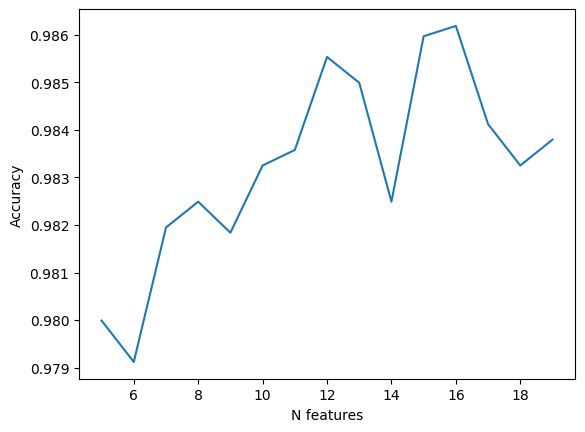

In [132]:
# lets select the best features 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

acc_results = []
n_features = []

# log_r = LogisticRegression(penalty='l1', solver='saga')
# xg = XGBClassifier(objective='multi:softmax',  # For multi-class classification
#     num_class=3,                # Adjust according to the number of classes
#     use_label_encoder=False,    # Avoid deprecated warning for label encoder
#     eval_metric='mlogloss'      # Log-loss metric for multi-class classification
# )

rf = RandomForestClassifier()
for i in range(5, 20):
    rfe = RFE(estimator = rf, n_features_to_select = i, step=1)
    rfe.fit(X, y)
    X_temp = rfe.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_temp,y, test_size = 0.2)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)

    start = time.time()
    scores = cross_val_score(rf, X_train, y_train ,scoring= 'accuracy', cv=5)
    print(" knn result :", "%0.3f, +- %0.3f" % (scores.mean(), scores.std()), 'N_features :', i)
    acc_results.append(scores.mean())
    n_features.append(i)

plt.plot(n_features, acc_results)
plt.ylabel('Accuracy')
plt.xlabel('N features')
plt.show()


In [133]:
rfe = RFE(estimator = rf, n_features_to_select = 16, step=1)
rfe.fit(X, y)
X_transformed = rfe.transform(X)

np.random.seed(50)

X_train, X_test, y_train, y_test = train_test_split(X_transformed,y, test_size = 0.2)

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


featured_columns = pd.DataFrame(rfe.support_,
                            index = X.columns,
                            columns=['is_in'])

featured_columns = featured_columns[featured_columns.is_in == True].index.tolist()

In [134]:
featured_columns

['Big Chances Missed_1_home',
 'Goals_1_home',
 'Big Chances_2_home',
 'Clean Sheets_3_home',
 'Corners Taken_4_home',
 'Goals Conceded_5_home',
 'Expected Goals_6_home',
 'Goals Conceded per Match_8_home',
 'Total Goals Conceded_8_home',
 'Possession (%)_9_home',
 'FotMob Team Rating_11_home',
 'Red Cards_13_home',
 'goals_difference',
 'expected_goals_difference',
 'goals_conceded_difference',
 'home_offensive_rating']

In [59]:
# from sklearn.preprocessing import StandardScaler
def optimize_model(X, y):
    # Preprocessing
    scaler = StandardScaler()
    # StandardScaler is better for logistic regression 
    X_scaled = scaler.fit_transform(X)

    model = KNeighborsClassifier(algorithm='auto')
    param_grid = {
    'n_neighbors': (1,3, 5, 10, 15),
    'leaf_size': (5, 10, 20,40),
    'p': (1,2,3,4),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev', 'euclidian'),
    }
    
    # Comprehensive Parameter Grid
    # param_grid = {
    #     'penalty': ['l1', 'l2'],  # Regularization type
    #     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    #     'solver': ['saga'],  # Optimization algorithms
    #     'class_weight': [None, 'balanced'],  # Handle class imbalance
    #     'multi_class': ['ovr','multinomial']  # Multiclass strategy
    # }

#     param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2, 0.3],
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 3, 5],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.01, 0.1],
#     'reg_lambda': [0, 0.01, 0.1],
#     'objective': ['multi:softmax'],  # Use 'binary:logistic' for binary classification
#     'num_class': [3],  # Only for multi-class, adjust based on your data
#     'booster': ['gbtree'],  # Or 'dart' if you want to experiment with Dropout Trees
# }
#     model = XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False)
    
    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='accuracy', 
        n_jobs=-1
    )
    
    grid_search.fit(X_scaled, y)
    
    # Best model details
    print("Best Parameters:")
    print(grid_search.best_params_)
    print("\nBest Cross-Validated Score:")
    print(f"{grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_

In [60]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=45)

# X_selected = X[featured_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [61]:
best_estimator =  optimize_model(X_resampled, y_resampled)

Best Parameters:
{'leaf_size': 5, 'metric': 'minkowski', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

Best Cross-Validated Score:
0.9161


In [62]:
y_pred=best_estimator.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.03      0.06       865
           1       0.48      0.93      0.63      1604
           2       0.42      0.12      0.18       980

    accuracy                           0.47      3449
   macro avg       0.46      0.36      0.29      3449
weighted avg       0.46      0.47      0.36      3449



In [ ]:
# current accuracy: 47%

# need to go back to the drawing board and reevaluate the features

# FOR REFERENCE: 

# 1: Home Team won 
# 0: Draw
# 2: Away Team won 
# total number of games = 11,494
# 5,331/11,494 ~ 46% 
# 2,936/11,494 ~ 25% 
# 3,227/11,494 ~ 28% 
# our baseline accuracy is 46% i.e choosing the majority class (home team) to win the game

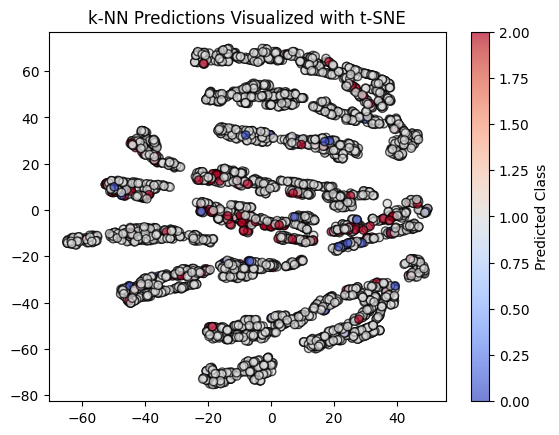

In [64]:
# VISUALIZE RESULTS
from sklearn.manifold import TSNE

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_test)

# Plot the predictions
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred, cmap='coolwarm', alpha=0.7, edgecolor='k')
plt.title("k-NN Predictions Visualized with t-SNE")
plt.colorbar(label="Predicted Class")
plt.show()

In [65]:
# this plot implies that our model is finding relationships ond structure in our data 
# as it is able to create clear groupings but we know that is not the case based on our accuracy 

In [66]:
# next steps should be to be more mindful during feature engineering